# ACF -- Ackerberg, Caves, Frazer -- Two-step GMM, simple version
* Uses two-step estimation, that is, first estimate $\Phi$. 
* Also makes the simplifying assumption of assuming $\omega_{it} = \rho\omega_{it-1} + \eta_{it}$
* This means there are 4 parameters to estimate; $\theta = (\beta_0, \beta_k, \beta_0, \rho)$

# Summary of the ACF method: 

Consider the "value-added" production function

$$y_{it} = \beta_0 + \beta_k k_{it} + \beta_l l_{it} + \omega_{it} + \epsilon_{it}$$

# Assumptions
* (I): Timing of Input Choices: Firms accumulate capital according to $k_{it} = \kappa\left(k_{it-1}, i_{it-1}\right)$, where investment $i_{it-1}$ is chosen in period $t-1.$ Labor input $l_{it}$ has potentially dynamic implications and is chosen at period $t$, period $t-1$, or period $t-b$ with $b\in (0, 1)$.
* (II): Scalar Unobservable: Firms' intermediate input demand is given by $m_{it} = \tilde f_t\left(k_{it}, l_{it}, \omega_{it}\right)$
* (III): Strict Monotonicity: $\tilde f_t\left(k_{it}, l_{it}, \omega_{it}\right)$ is strictly increasing in $\omega_{it}$. That is, the amount of input demanded is strictly increasing in productivity.

Note that we consider a "value-added" production function, in the sense that the intermediate input $m_{it}$ does not enter the production function to be estimated. 
* One interpretation: Gross output production function is Leontief in the intermediate input, where this intermediate input is proportional to output.

Given these assumptions, following Levinsohn and Petrin, we can invert intermediate input demand to recover the productivity: 

$$\omega_{it}= \tilde f_t^{-1}\left(k_{it}, l_{it}, m_{it}\right).$$

Then, we can substitute into the production function: 

$$
\begin{aligned}
    y_{it} & = \beta_0 + \beta_k k_{it} + \beta_l l_{it} +  f_t^{-1}\left(k_{it}, l_{it}, m_{it}\right) + \varepsilon_{it} \\
    & = \tilde \Phi_t(k_{it}, l_{it}, m_{it}) + \varepsilon_{it}
\end{aligned}
$$

ACF follow LP and treat $f_t^{-1}$ nonparametrically, so, the first three terms $\beta_0, \beta_k, \beta_l$ are not identified and subsumed into $\tilde \Phi_t(k_{it}, l_{it}, m_{it}) = \beta_0+\beta_k k_{it} + \beta_l l_{it} + \omega_{it}$, resulting in the following first-stage moment condition:

$$
E\left[\epsilon_{it} \big| \mathcal I_{it}\right] = E\left[y_{it}- \tilde \Phi_t(k_{it}, l_{it}, m_{it}) \big| \mathcal I_{it}\right]
$$

where $\mathcal I_{it-1}$ is the information set of firm $i$ at time $t-1$. 

From here, we can estimate $\hat{\tilde \Phi}_t$ nonparametrically. 

Next, we can use the second-stage conditional moment

$$
\begin{aligned}
& E[\xi_{it} + \varepsilon_{it} \big| \mathcal I_{it-1}] = \\
& E\left[y_{it} - \beta_0 - \beta_k k_{it} - \beta_l l_{it} - g\left(\hat{\tilde \Phi}_{t-1}(k_{it-1}, l_{it-1}, m_{it-1}) - \beta_0 - \beta_k k_{it-1} - \beta_l l_{it-1}\right)\bigg| \mathcal I_{it-1}\right] = 0
\end{aligned}
$$

where the function $g(\cdot) = E[\omega_{it}|\omega_{it-1}]$ comes from:

$$
\omega_{it} = E[\omega_{it}|\mathcal I_{it-1}] + \xi_{it} = E[\omega_{it}|\omega_{it-1}]+\xi_{it} = g(\omega_{it-1}) + \xi_{it}
$$

# Identification Procedure:
For a simple example, suppose $\omega_{it} = \rho \omega_{it-1} + \xi_{it}.$ Then
$g(x) = E[x|\omega_{it-1}] = \rho \omega_{it-1}.$ Assume labor is chosen after time $t-1$. Then the estimation procedure is: 

## (1) Regress $y_{it}$ on $\left(k_{it}, l_{it}, m_{it}\right)$ nonparametrically, or using a high-order polynomial, to obtain $\hat{\tilde \Phi}_t\left(k_{it}, l_{it}, m_{it}\right).$

We do this for every period to get a sequence of functions of $(k, l, m).$ These will be plugged in for $\Phi$ in the next step. 

## (2) Use the following four moment conditions to estimate the parameters $\left(\beta_0, \beta_k, \beta_l, \rho\right):$

$$
E\left[\left(y_{it} - \beta_0 - \beta_k k_{it} - \beta_l l_{it} - \rho\left(\tilde \Phi_{t-1}\left(k_{it-1}, l_{it-1}, m_{it-1}\right) - \beta_0 - \beta_k k_{it-1} - \beta_l l_{it-1}\right)\right) \otimes \begin{pmatrix} 1 \\ k_{it} \\ l_{it-1} \\ \tilde \Phi_{t-1}\left(k_{it-1}, l_{it-1}, m_{it-1}\right) \\ \end{pmatrix} \right] = 0
$$

Here's where we use GMM. 

# Load in the data


In [12]:
import autograd.numpy as np
from autograd import grad
#import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from itertools import combinations_with_replacement, chain

In [13]:
filename = "../PS3_data_changedtoxlsx.xlsx"
df0 = pd.read_excel(filename)
#Remove missing materials columns
df = df0[['year', 'firm_id', 'X03', 'X04', 'X05', 'X16', 'X40', 'X43', 'X44', 'X45', 'X49']]
#new_names = ["year", "firm_id", "obs", "ly", "s01", "s02", "lc", "ll", "lm"]
new_names = ["t", "firm_id", "y_gross", "s01", "s02", "s13", "k", "l", "m", 'py', 'pm']
df.columns = new_names
#Drop missing materials data
df=df[df['m']!=0]
#Keep industry 1 only
df=df[df['s13']==1]

#Creating value-added y
df['y'] = np.log(np.exp(df['y_gross'] + df['py']) - np.exp(df['m'] + df['pm']))

#Creating lagged variables
df = df.sort_values(by=['firm_id', 't'])
df['kprev'] = df.groupby('firm_id')['k'].shift(1)
df['lprev'] = df.groupby('firm_id')['l'].shift(1)
df['mprev'] = df.groupby('firm_id')['m'].shift(1)

# First step of coding: Write functions for the estimation of $\tilde \Phi_t.$

In [14]:
def poly_terms(n_features, degree):
    #This thing creates an iterator structure of tuples, used to create polynomial interaction terms. 
    #It looks something like this: (0,), (1,), (2,), (0, 0), (0, 1) 
    polynomial_terms = chain(
        *(combinations_with_replacement(range(n_features), d) for d in range(1, degree+1))
    )
    return(polynomial_terms)

def fit_phi_poly(y, xvars, degree):
    #Get number of observations (n) and number of independent variables (k)
    if xvars.ndim == 1:
        xvars = xvars.reshape(1, -1)
    # Get the number of samples (n) and number of features (m) from X
    n_samples, n_features = xvars.shape
    # Start with a column of ones for the intercept term
    X_poly = np.ones((n_samples, 1))
    #Create iterator used to construct polynomial terms
    polynomial_terms = poly_terms(n_features, degree)
    # Generate polynomial terms and interaction terms up to 4th degree
    for terms in  polynomial_terms:  # For degrees 1 to 4
            X_poly = np.hstack((X_poly, np.prod(xvars[:, terms], axis=1).reshape(-1, 1)))
    # Compute the coefficients using the normal equation: beta = (X.T * X)^(-1) * X.T * y
    XT_X = X_poly.T @ X_poly
    XT_X_inv = np.linalg.inv(XT_X)
    XT_y = X_poly.T @ y
    beta = XT_X_inv @ XT_y

    return beta, X_poly

## Estimate $\Phi$

In [15]:
degree= 3
xvars = df[['k', 'l', 'm']].to_numpy()
y = df[['y']].to_numpy()
gammas, X_poly = fit_phi_poly(y, xvars, degree)
Phi = X_poly @ gammas

#phi_beta_dict = fit_phi_poly_years(df, degree)
df["Phi"] = Phi
#Add into the dataframe
df['Phiprev'] = df.groupby('firm_id')['Phi'].shift(1)
#drop NaNs

## Actual by predicted plot for my polynomial approximation of $\Phi$, run on the entire sample

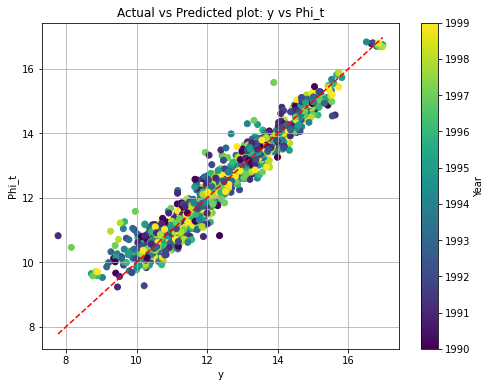

In [16]:
#Actual vs Predicted plot
# Assuming df is a structured NumPy array
actual_values = df['y']     # Extract the actual values
predicted_values = df['Phi'] # Extract the predicted values
years = df['t']

# Create the plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(actual_values, predicted_values, c=years, cmap='viridis', label='Predicted vs Actual')
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--', label='Perfect Fit')

# Add a color bar to represent the year scale
cbar = plt.colorbar(scatter)
cbar.set_label('Year')

# Add labels and title
plt.xlabel('y')
plt.ylabel('Phi_t')
plt.title('Actual vs Predicted plot: y vs Phi_t')
plt.grid(True)

# Show the plot
plt.show()

Now, we've calculated Phi and its lagged value. 
## Next step: "Concentrate out" additional moments

let 

$$
\widehat{\tilde\beta_0 + \omega_{it}(\beta_k, \beta_l)} = \hat{\tilde \Phi_t}(k_{it}, l_{it}, m_{it}) - \beta_k k_{it} - \beta_l l_{it}
$$

Then regress $\widehat{\tilde\beta_0 + \omega_{it}(\beta_k, \beta_l)}$ on $\widehat{\tilde\beta_0 + \omega_{it-1}(\beta_k, \beta_l})$, noting that the residuals of this regression are the implied values of the innovations in omega, that is, $\hat \xi_{it}(\beta_k, \beta_l).$

Notice that this regression implicitly makes these innovations mean zero and uncorrelated with $\omega_{it-1}(\beta_k, \beta_l)$, so it is similar to enforcing the first and fourth moments in the "four moments" version of this etimation. 

Then, search over $\beta_k$ and $\beta_l$ to satisfy the moment conditions: 

$$
E\left[ \hat \xi_{it}(\beta_k, \beta_l) \otimes \begin{pmatrix}k_{it} \\ l_{it-1}\end{pmatrix} \right] = 0. 
$$



In [17]:
#Calculates the error term, h(theta, y, k, l)
def moment_error_ACF(theta, y, k, l, kprev, lprev, Phi, Phiprev):
    #get the innovations to omega
    beta_k = theta[0]
    beta_l = theta[1]
    b0_plus_omega = Phi - beta_k*k - beta_l*l 
    b0_plus_omega_prev = Phiprev - beta_k*kprev - beta_l*lprev 
    #Regress them to get the innovations
    yvar = b0_plus_omega#.reshape(-1, 1)
    xvar = b0_plus_omega_prev.reshape(-1, 1)
    #Degree of the Omega polynomial
    omega_degree = 1
    coeffs, Xdesign = fit_phi_poly(yvar, xvar, degree = omega_degree)
    #evaluate
    b0_plus_omega_hat = Xdesign@coeffs
    #Get residual
    xi = b0_plus_omega -  b0_plus_omega_hat
    #xi = fit_phi_poly(df['b0_plus_omega'].to_numpy().reshape(1, -1), df['b0_plus_omega'].to_numpy().reshape(1, -1), degree=1)
    #remove nans (associated with the lag) -- this is ok because we're just using this vector as part of a dot product. 
    return xi, coeffs[1]

def moment_ex_restrictions_ACF(k, lprev):
    #Moment conditions include exogeneity restrictions for 1, k_{it}, l_{it-1}, and Phi. 
    #Put them all in one matrix for easy access, called Vexc (short for vectors for exogeneity restrictions)
    #Replace all nans with zeros -- this is ok, because we're just taking a dot product over each row of this matrix, and want to remove the nans
    Vex = np.vstack([
        k, 
        lprev])
    return Vex

def gmm_obj_ACF(theta, y, k, l, kprev, lprev, Phi, Phiprev, Vex, W):
    #Arguments
    #Get the vector h(theta, y, k, l)
    xi = moment_error_ACF(theta, y, k, l, kprev, lprev, Phi, Phiprev)[0]
    #Calculate the "error" -- exogenous terms (dotproduct) h(theta, y, k, l)
    err = (Vex@xi)/len(xi)
    #Calculate the weighted sum of the error using the weight matrix, W
    obj = err.T@W@err
    return obj

## Getting data series used in the estimator

In [18]:
df_nonans = df.dropna()
#Get all the variables out of the dataframe -- This allows me to use Autograd
y = df_nonans['y'].to_numpy() 
k = df_nonans['k'].to_numpy()  
l = df_nonans['l'].to_numpy()  
Phi = df_nonans['Phi'].to_numpy() 
kprev = df_nonans['kprev'].to_numpy()  
lprev = df_nonans['lprev'].to_numpy() 
Phiprev = df_nonans['Phiprev'].to_numpy() 
#Run GMM
#Initial guess for parameters beta_0, beta_k, beta_l, rho
theta0 = np.array([1,1])
#Weight matrix -- use the identity for now. 
W0 = np.eye(2)
#(2) Get matrix of variables used in exogeneity restrictions
Vex = moment_ex_restrictions_ACF(k, lprev)
#Evaluate the GMM error
obj = gmm_obj_ACF(theta0, y, k, l, kprev, lprev, Phi, Phiprev, Vex, W0)

#Create  automatic gradient
autogradient = grad(gmm_obj_ACF)

#
xi = moment_error_ACF(theta0, y, k, l, kprev, lprev, Phi, Phiprev)[0]

autogradient(np.array([0.323, 0.731]), y, k, l, kprev, lprev, Phi, Phiprev, Vex, W0)


array([-0.00056613, -0.00034425])

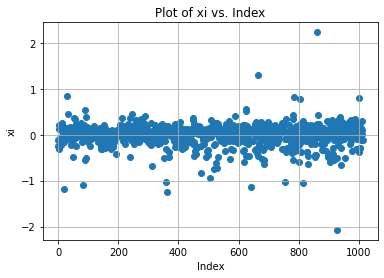

In [19]:
plt.scatter(range(len(xi)), xi, marker='o', linestyle='-')
plt.xlabel("Index")
plt.ylabel("xi")
plt.title("Plot of xi vs. Index")
plt.grid(True)
plt.show()

## Now, use a minimization routine to optimize for theta. 
It seems pretty robust, even to crazy initial conditions like $\left[\beta_k, \beta_l\right] = \left[100, 100\right]$

In [31]:
#theta0 = np.array([1, 1])
theta0 = np.array([1,1])*1   ### Seems pretty robust to crazy initial conditions

#Weight matrix -- use the identity for now. 
W0 = np.eye(2)
#(2) Get matrix of variables used in exogeneity restrictions
Vex = moment_ex_restrictions_ACF(k, lprev)

gmm_args = (y, k, l, kprev, lprev, Phi, Phiprev, Vex, W0)


theta_results = opt.minimize(gmm_obj_ACF, theta0, args=gmm_args,
                        tol=1e-16, method='Nelder-Mead', options={'maxiter': 20000})

theta_results_grad = opt.minimize(gmm_obj_ACF, theta0, args=gmm_args,
                       tol=1e-16, jac=autogradient, method='L-BFGS-B',                              
                        options={'ftol': 1e-16, 'gtol': 1e-16, 'maxiter': 20000})

#autogradient(theta_results, *gmm_args)

theta=theta_results.x
#Get the slope, rho. It's the slope of the regression used to find the moments. 
rho = moment_error_ACF(theta, y, k, l, kprev, lprev, Phi, Phiprev)[1]

print("The GMM error using Nelder-Mead is:", gmm_obj_ACF(theta, y, k, l, kprev, lprev, Phi, Phiprev, Vex, W0))
print("The estimates using Nelder-Mead are: [beta_k, beta_l] = ", theta)
print("The slope of the AR(1) of productivity is: rho = ", rho)
print("The GMM error using the gradient is:", gmm_obj_ACF(theta_results_grad.x, y, k, l, kprev, lprev, Phi, Phiprev, Vex, W0))
print("The estimates using autograd: [beta_k, beta_l] = ", theta_results_grad.x)
print("The gradient at the optimum is: ", autogradient(theta_results_grad.x, y, k, l, kprev, lprev, Phi, Phiprev, Vex, W0))
#print("The gradient at [0,0] is: ", autogradient(np.array([0.0,0.0]), y, k, l, kprev, lprev, Phi, Phiprev, Vex, W0))


The GMM error using Nelder-Mead is: 4.829354783036153e-26
The estimates using Nelder-Mead are: [beta_k, beta_l] =  [0.3235676  0.73189068]
The slope of the AR(1) of productivity is: rho =  0.882158675085293
The GMM error using the gradient is: 4.553335755777667e-23
The estimates using autograd: [beta_k, beta_l] =  [0.3235676  0.73189068]
The gradient at the optimum is:  [5.50565528e-12 3.03890086e-12]


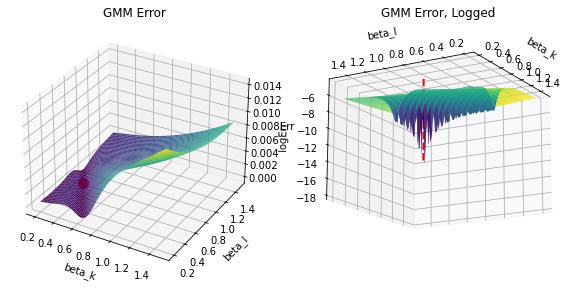

In [21]:
#plotrange = np.linspace(-1, 10, 300)
plotrange = np.linspace(0.2, 1.5, 300)
# Define the grid over which to plot
theta_grid1 = plotrange
theta_grid2 = plotrange
TH1, TH2 = np.meshgrid(theta_grid1, theta_grid2)

# Define the function to plot
# Calculate Z values using a for loop
Z0 = np.zeros_like(TH1)
for i in range(TH1.shape[0]):
    for j in range(TH1.shape[1]):
        TH = np.array([TH1[i, j], TH2[i, j]])
        Z0[i, j] = gmm_obj_ACF(TH, y, k, l, kprev, lprev, Phi, Phiprev, Vex, W0 )

Zlog = np.log(Z0)
Z = Z0

#Our estimated value
x0, y0 = theta_results.x[0], theta_results.x[1]  
z0 = gmm_obj_ACF(np.array([x0, y0]), y, k, l, kprev, lprev, Phi, Phiprev, Vex, W0 )

# Create the figure and 3D axis
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')  # Second subplot for logged

# Plot the unlogged surface
surf1 = ax1.plot_surface(TH1, TH2, Z, cmap='viridis')
#fig.colorbar(surf1, ax=ax1, shrink=0.2, aspect=5)
ax1.set_xlabel('beta_k')
ax1.set_ylabel('beta_l')
ax1.set_zlabel('Err')
ax1.set_title('GMM Error')

# Plot the logged surface
surf2 = ax2.plot_surface(TH1, TH2, Zlog, cmap='viridis')
#fig.colorbar(surf2, ax=ax2, shrink=0.2, aspect=5)
ax2.set_xlabel('beta_k')
ax2.set_ylabel('beta_l')
ax2.set_zlabel('logErr')
ax2.set_title('GMM Error, Logged')
# Draw a vertical line from the surface point down to z=0
ax2.plot([x0, x0], [y0, y0], [-5, -15], color='red', linewidth=2, linestyle='--')
# Plot the surface
# Draw a vertical line from the surface point down to z=0
ax1.scatter(x0, y0, z0, color='red', s=100, marker='o')
#ax2.scatter(x0, y0, z0, color='red', s=100, marker='o')

# Set labels
#ax2.set_zscale('log')

#x1.view_init(elev=0, azim=200)  # Adjust azim to rotate right
ax2.view_init(elev=-15, azim=-150)  # Adjust azim to rotate right
plt.show()

## The surface is very flat and difficult to find an optimum over. I think the spikes in the log plot are due to numerical error. 
But, it looks like we got roughly close to the optimum. 

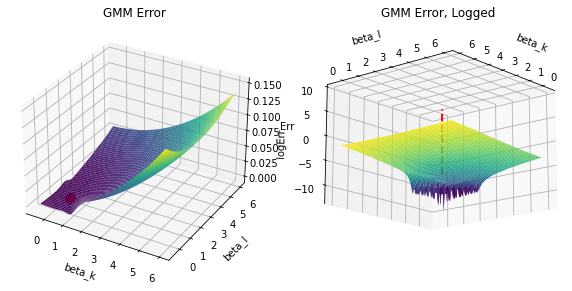

In [22]:
plotrange = np.linspace(-0.5, 6, 300)
#plotrange = np.linspace(0.3, 0.7, 300)
# Define the grid over which to plot
theta_grid1 = plotrange
theta_grid2 = plotrange
TH1, TH2 = np.meshgrid(theta_grid1, theta_grid2)

# Define the function to plot
# Calculate Z values using a for loop
Z0 = np.zeros_like(TH1)
for i in range(TH1.shape[0]):
    for j in range(TH1.shape[1]):
        TH = np.array([TH1[i, j], TH2[i, j]])
        Z0[i, j] = gmm_obj_ACF(TH, y, k, l, kprev, lprev, Phi, Phiprev, Vex, W0 )

Zlog = np.log(Z0)
Z = Z0

#Our estimated value
x0, y0 = theta_results.x[0], theta_results.x[1]  
z0 = gmm_obj_ACF(np.array([x0, y0]), y, k, l, kprev, lprev, Phi, Phiprev, Vex, W0 )

# Create the figure and 3D axis
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')  # Second subplot for logged


# Plot the unlogged surface
surf1 = ax1.plot_surface(TH1, TH2, Z, cmap='viridis')
#fig.colorbar(surf1, ax=ax1, shrink=0.2, aspect=5)
ax1.set_xlabel('beta_k')
ax1.set_ylabel('beta_l')
ax1.set_zlabel('Err')
ax1.set_title('GMM Error')

# Plot the logged surface
surf2 = ax2.plot_surface(TH1, TH2, Zlog, cmap='viridis')
#fig.colorbar(surf2, ax=ax2, shrink=0.2, aspect=5)
ax2.set_xlabel('beta_k')
ax2.set_ylabel('beta_l')
ax2.set_zlabel('logErr')
ax2.set_title('GMM Error, Logged')
# Draw a vertical line from the surface point down to z=0
ax2.plot([x0, x0], [y0, y0], [-4, 10], color='red', linewidth=2, linestyle='--')
# Plot the surface
# Draw a vertical line from the surface point down to z=0
ax1.scatter(x0, y0, z0, color='red', s=100, marker='o')
#ax2.scatter(x0, y0, np.log(z0), color='red', s=100, marker='o')

# Set labels
#ax.set_zscale('log')

#x1.view_init(elev=0, azim=200)  # Adjust azim to rotate right
ax2.view_init(elev=-15, azim=-320)  # Adjust azim to rotate right
plt.show()

# Plotting over a wider range, it looks like there are two (or more) local optimums. 